In [1]:
# Imports and paths
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import pandas as pd
import numpy as np
from pathlib import Path

BASE = Path.cwd().parents[0]
REPORTS = BASE / "reports"
MODELS = BASE / "models"
DATA_PROCESSED = BASE / "data" / "processed"
REPORTS.mkdir(exist_ok=True)

SYMBOLS = ["QQQ", "VFV.TO", "XEQT.TO"]

sns.set(style="whitegrid")

In [2]:
# Loading metrics
metrics_all = pd.read_csv(REPORTS / "day4_cv_metrics_summary.csv", index_col=[0,1])
display(metrics_all)

ACC     AUC      F1     MAE      R2    RMSE
symbol  algo                                                     
QQQ     hgb_reg       NaN     NaN     NaN  0.0108 -0.3555  0.0154
        logit_cls  0.5191  0.5008  0.5779     NaN     NaN     NaN
        ridge_reg     NaN     NaN     NaN  0.0094 -0.0041  0.0134
VFV.TO  hgb_reg       NaN     NaN     NaN  0.0079 -0.2421  0.0113
        logit_cls  0.4960  0.5064  0.5039     NaN     NaN     NaN
        ridge_reg     NaN     NaN     NaN  0.0071 -0.0385  0.0104
XEQT.TO hgb_reg       NaN     NaN     NaN  0.0070 -0.4194  0.0095
        logit_cls  0.4797  0.5000  0.4640     NaN     NaN     NaN
        ridge_reg     NaN     NaN     NaN  0.0063 -0.1092  0.0084

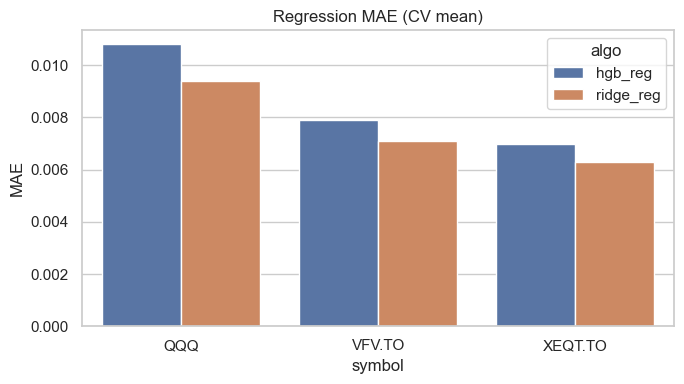

Saved /Users/itzronald/Desktop/trend-predictor/reports/day5_reg_MAE.png


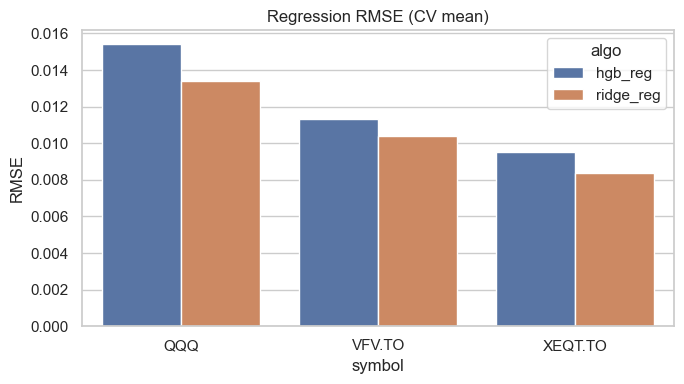

Saved /Users/itzronald/Desktop/trend-predictor/reports/day5_reg_RMSE.png


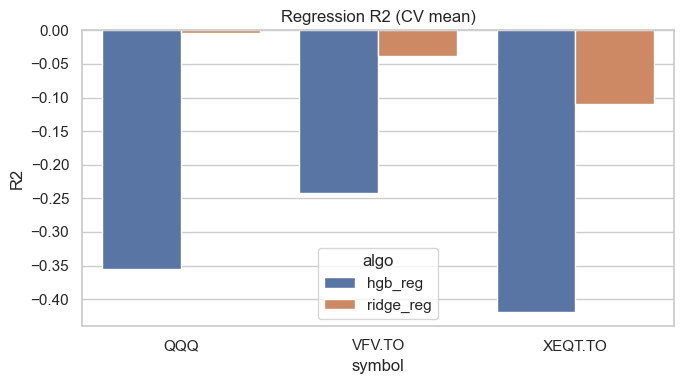

Saved /Users/itzronald/Desktop/trend-predictor/reports/day5_reg_R2.png


In [3]:
# metrics for regression models

def plot_regression_metrics(metrics_path: Path):
    df = pd.read_csv(metrics_path)
    df = df.pivot_table(index=["symbol","algo"], values=["MAE","RMSE","R2"])
    df = df.reset_index()

    for metric in ["MAE","RMSE","R2"]:
        plt.figure(figsize=(7,4))
        sns.barplot(data=df, x="symbol", y=metric, hue="algo")
        plt.title(f"Regression {metric} (CV mean)")
        plt.tight_layout()
        fname = REPORTS / f"day5_reg_{metric}.png"
        plt.savefig(fname, dpi=150)
        plt.show()
        print("Saved", fname)

plot_regression_metrics(REPORTS / "day4_cv_metrics_summary.csv")


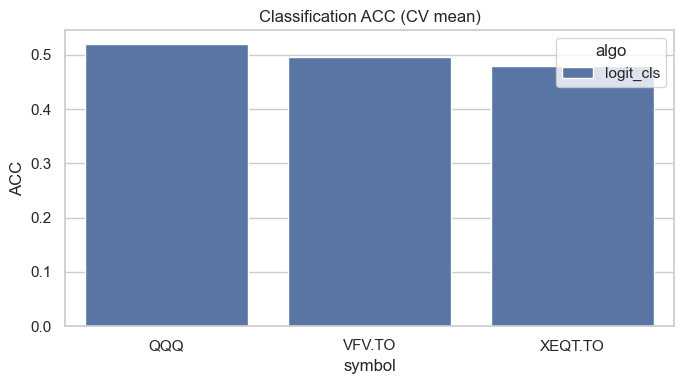

Saved /Users/itzronald/Desktop/trend-predictor/reports/day5_cls_ACC.png


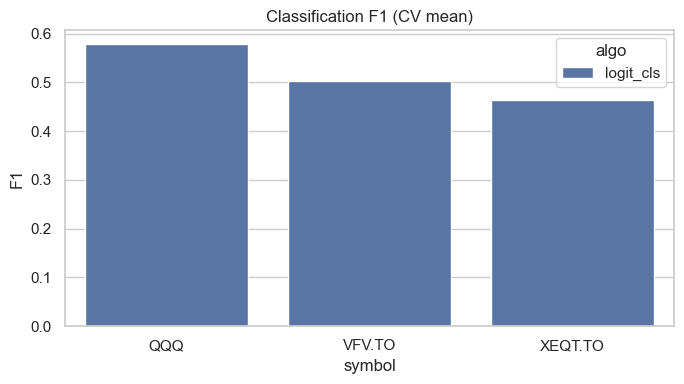

Saved /Users/itzronald/Desktop/trend-predictor/reports/day5_cls_F1.png


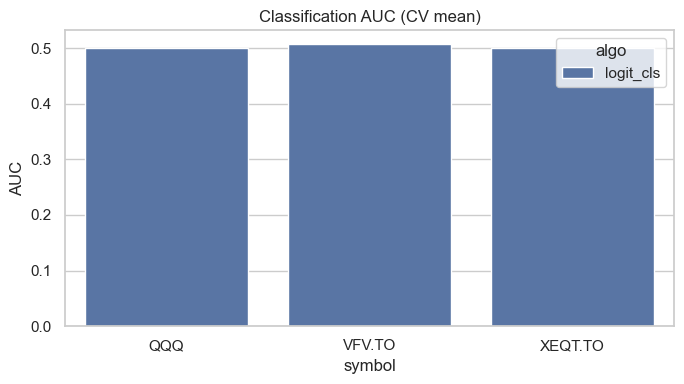

Saved /Users/itzronald/Desktop/trend-predictor/reports/day5_cls_AUC.png


In [4]:
# Metrics for classification models

def plot_classification_metrics(metrics_path: Path):
    df = pd.read_csv(metrics_path)
    df = df[df["algo"].str.contains("cls")]
    df = df.pivot_table(index=["symbol","algo"], values=["ACC","F1","AUC"])
    df = df.reset_index()

    for metric in ["ACC","F1","AUC"]:
        plt.figure(figsize=(7,4))
        sns.barplot(data=df, x="symbol", y=metric, hue="algo")
        plt.title(f"Classification {metric} (CV mean)")
        plt.tight_layout()
        fname = REPORTS / f"day5_cls_{metric}.png"
        plt.savefig(fname, dpi=150)
        plt.show()
        print("Saved", fname)

plot_classification_metrics(REPORTS / "day4_cv_metrics_summary.csv")


In [9]:
# Helper functions for permutation importances in the next cell
def load_dataset(symbol: str) -> pd.DataFrame:
    """
    Load a processed dataset for a symbol from data/processed.
    """
    path = DATA_PROCESSED / f"{symbol}_dataset.parquet"
    df = pd.read_parquet(path)
    df = df.sort_values("date").reset_index(drop=True)
    return df

def make_X_y(df: pd.DataFrame, task: str):
    """
    Split dataset into X, y, and dates for regression/classification.
    task: "reg" -> y_reg, "cls" -> y_cls
    """
    feats = df.drop(columns=["date","y_reg","y_cls"])
    if task == "reg":
        y = df["y_reg"].values
    else:
        y = df["y_cls"].values
    X = feats.values.astype(float)
    dates = pd.to_datetime(df["date"].values)
    return X, y, dates, feats.columns.tolist()

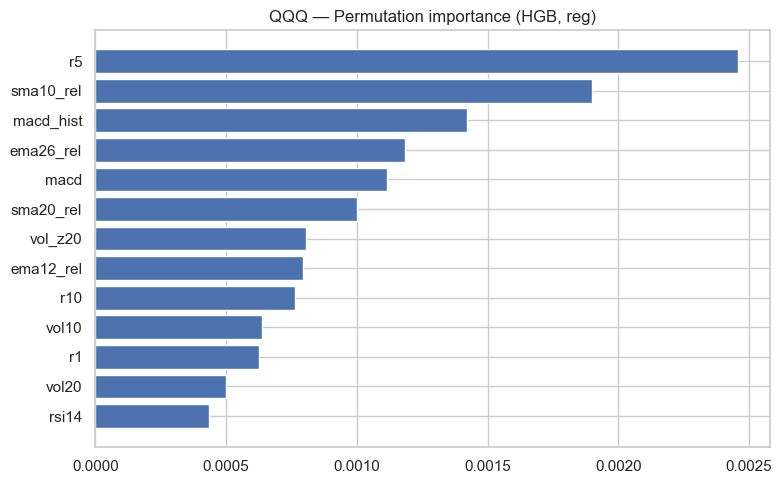

Saved /Users/itzronald/Desktop/trend-predictor/reports/day5_QQQ_hgb_perm_importance.png


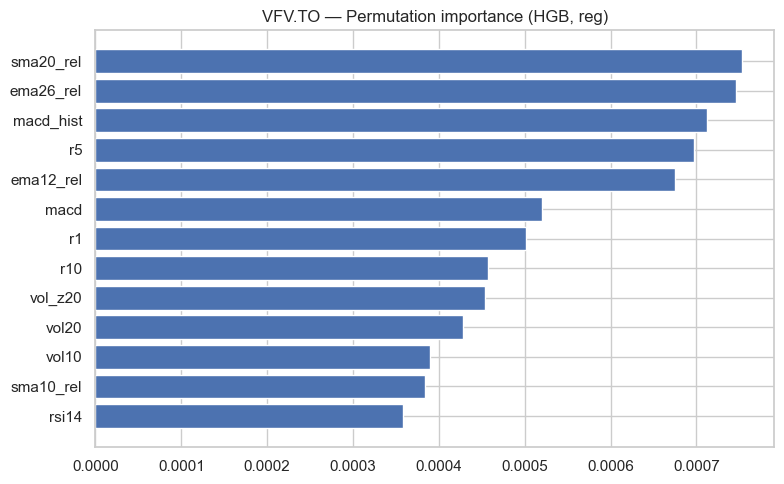

Saved /Users/itzronald/Desktop/trend-predictor/reports/day5_VFV.TO_hgb_perm_importance.png


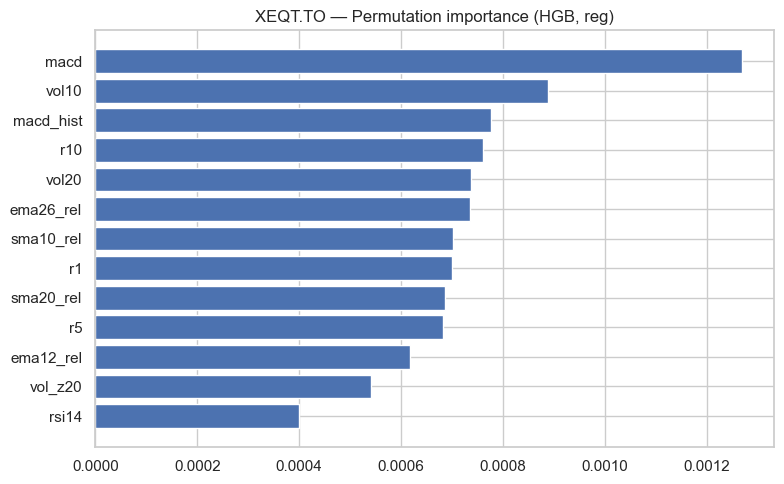

Saved /Users/itzronald/Desktop/trend-predictor/reports/day5_XEQT.TO_hgb_perm_importance.png


In [10]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import joblib
from pathlib import Path

def plot_perm_importances(symbol: str, task: str = "reg", n_repeats: int = 10):
    # load model bundle saved on Day 4
    bundle = joblib.load(MODELS / f"{symbol}_hgb_{'reg' if task=='reg' else 'cls'}.pkl")
    model = bundle["model"]
    trained_feats = bundle["features"]

    # load dataset
    df = load_dataset(symbol)
    X, y, dates, feat_names = make_X_y(df, task=task)

    # reorder columns to match training feature order (safety)
    if feat_names != trained_feats:
        col_idx = [feat_names.index(c) for c in trained_feats]
        X = X[:, col_idx]

    # use the last 20% as a holdout for importance (avoids peeking too much)
    n = len(X)
    split = int(n * 0.8)
    X_test, y_test = X[split:], y[split:]

    scoring = "neg_mean_absolute_error" if task == "reg" else "roc_auc"
    r = permutation_importance(
        model, X_test, y_test,
        n_repeats=n_repeats,
        random_state=42,
        scoring=scoring
    )

    imp = pd.DataFrame({
        "feature": trained_feats,
        "importance": r.importances_mean,
        "std": r.importances_std
    }).sort_values("importance", ascending=False)

    # plot top 15
    top = imp.head(15)
    plt.figure(figsize=(8,5))
    plt.barh(top["feature"][::-1], top["importance"][::-1])
    plt.title(f"{symbol} — Permutation importance (HGB, {task})")
    plt.tight_layout()
    fname = REPORTS / f"day5_{symbol}_hgb_perm_importance.png"
    plt.savefig(fname, dpi=150)
    plt.show()
    print("Saved", fname)
    return imp

for sym in SYMBOLS:
    _ = plot_perm_importances(sym, task="reg", n_repeats=10)